In [ ]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# 1. ----- path to summary_rounds_withCache.json (updated path) --------
summary_path = Path(
    "./sonet_openhands/"
    "claude-3-7-sonnet-20250219_maxiter_100_N_v0.31.0-no-hint-juan-inst-t1-run_1_all_interaction_extract/"
    "astropy__astropy-7336/summary_rounds_withCache.json"  # Changed to withCache
)

# astropy__astropy-13236
with summary_path.open() as fh:
    js = json.load(fh)

rounds = js["rounds"]  # dict keyed by "interaction_01__..."
# ---------------------------------------------------------------------


# ---------------------------------------------------------------------
# 2. ----- tidy into a DataFrame (updated to include cache columns) ----
records = []
for k, v in rounds.items():
    interaction_num = int(k.split("_")[1])  # "interaction_09__..." -> 9
    records.append(
        dict(
            round=interaction_num,
            prompt_tokens=v["prompt_tokens"],
            completion_tokens=v["completion_tokens"],
            cost=v["cost"],
            tool_output_tokens=v["tool_output_tokens"],
            tool_name=v["tool_executed_name"],
            # Add cache-related columns
            cached_tokens=v["cached_tokens"],
            cache_creation_input_tokens=v["cache_creation_input_tokens"],
            cache_read_input_tokens=v["cache_read_input_tokens"],
        )
    )

df = pd.DataFrame(records).sort_values("round").reset_index(drop=True)
print(df.head())

   round  prompt_tokens  completion_tokens      cost  tool_output_tokens  \
0      1           4965                426  0.017975                   0   
1      2           6596                187  0.015304                 583   
2      3           6803                 91  0.004755                  12   
3      4           7102                154  0.006383                 150   
4      5           7330                110  0.005333                  51   

            tool_name  cached_tokens  cache_creation_input_tokens  \
0                none           3398                         1564   
1        execute_bash           4962                         1629   
2  str_replace_editor           6591                          207   
3        execute_bash           6798                          299   
4        execute_bash           7097                          228   

   cache_read_input_tokens  
0                     3398  
1                     4962  
2                     6591  
3           

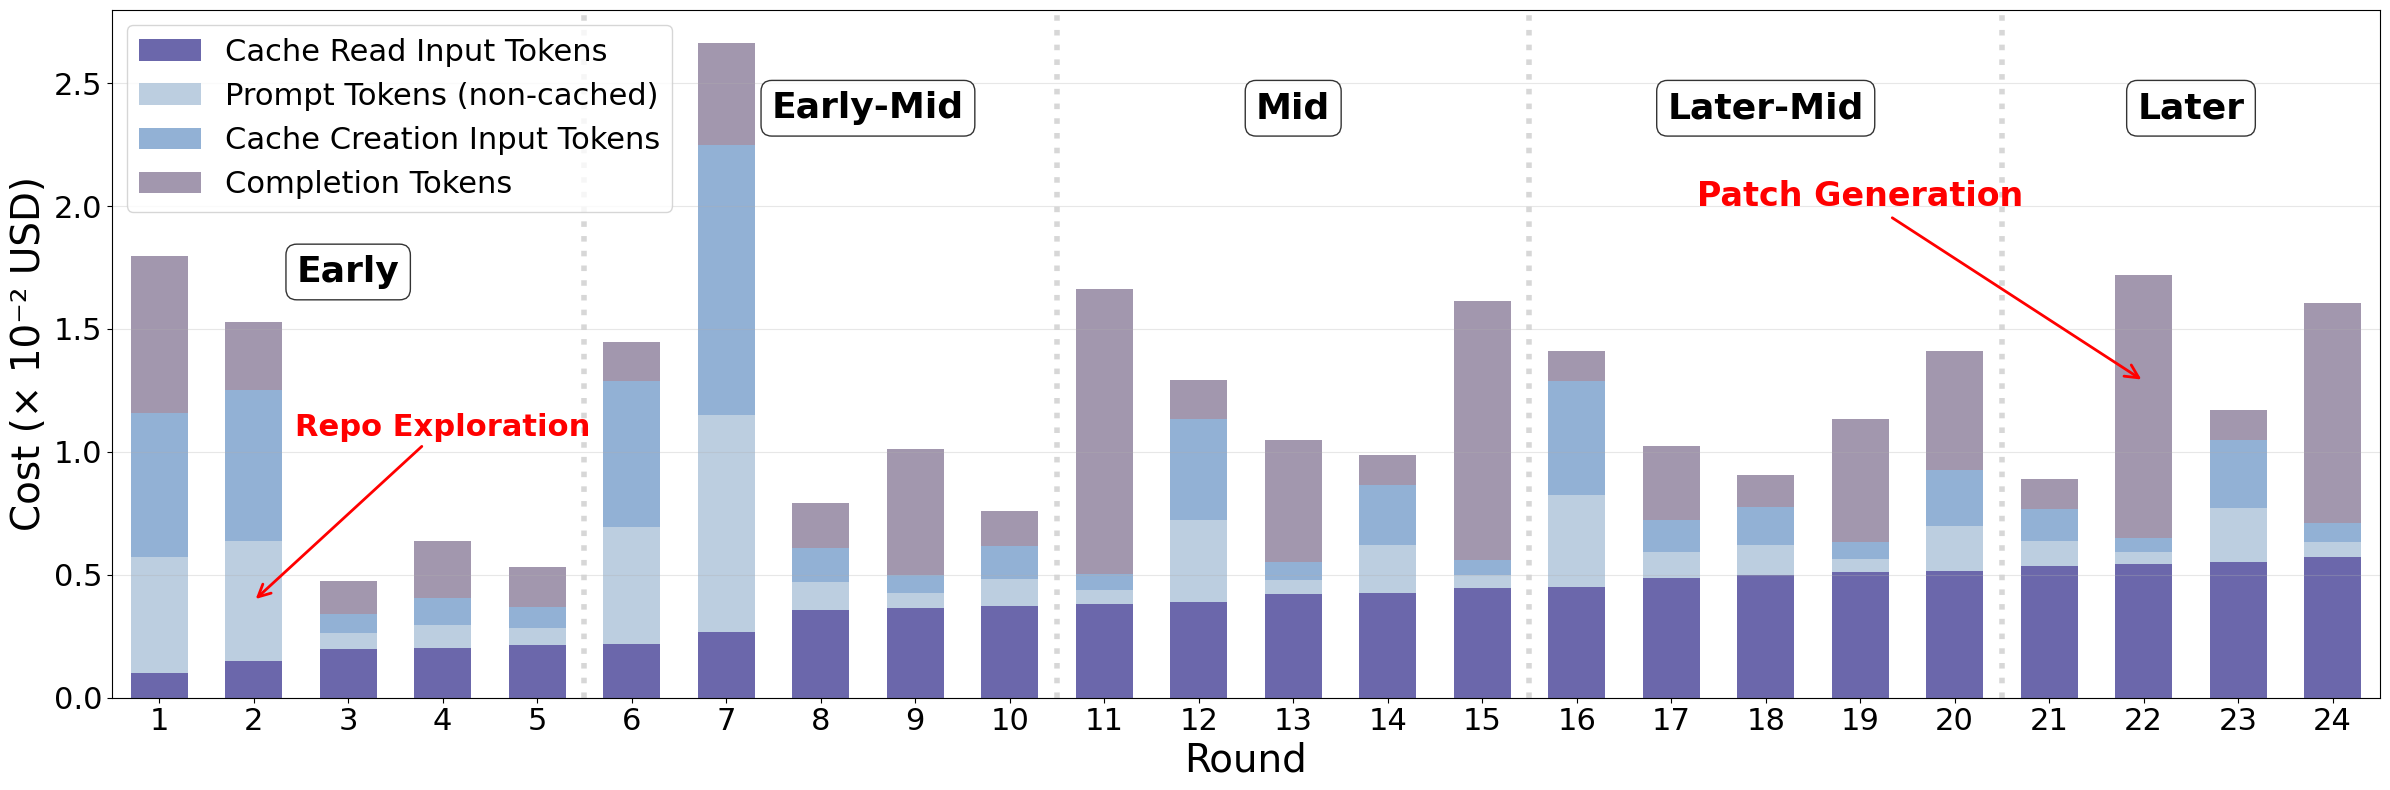

Detailed Cost Breakdown by Round:
Round  1: Total=$0.0180 | Prompt=$0.0047 | Completion=$0.0064 | Cache_Creation=$0.0059 | Cache_Read=$0.0010
Round  2: Total=$0.0153 | Prompt=$0.0049 | Completion=$0.0028 | Cache_Creation=$0.0061 | Cache_Read=$0.0015
Round  3: Total=$0.0048 | Prompt=$0.0006 | Completion=$0.0014 | Cache_Creation=$0.0008 | Cache_Read=$0.0020
Round  4: Total=$0.0064 | Prompt=$0.0009 | Completion=$0.0023 | Cache_Creation=$0.0011 | Cache_Read=$0.0020
Round  5: Total=$0.0053 | Prompt=$0.0007 | Completion=$0.0016 | Cache_Creation=$0.0009 | Cache_Read=$0.0021
Round  6: Total=$0.0145 | Prompt=$0.0048 | Completion=$0.0016 | Cache_Creation=$0.0059 | Cache_Read=$0.0022
Round  7: Total=$0.0266 | Prompt=$0.0088 | Completion=$0.0041 | Cache_Creation=$0.0110 | Cache_Read=$0.0027
Round  8: Total=$0.0079 | Prompt=$0.0011 | Completion=$0.0018 | Cache_Creation=$0.0014 | Cache_Read=$0.0036
Round  9: Total=$0.0101 | Prompt=$0.0006 | Completion=$0.0051 | Cache_Creation=$0.0007 | Cache_Read=$0

In [7]:
# ---------------------------------------------------------------------
#  Bar Plot - Exact Token Costs (Real Numbers) by Round
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for stacked bar chart - reordered so blue (prompt) is at bottom, green (cache creation) is second
cost_columns = ['cache_read_cost', 'prompt_cost', 'cache_creation_cost', 'completion_cost']
cost_labels = ['Cache Read Input Tokens', 'Prompt Tokens (non-cached)', 'Cache Creation Input Tokens', 'Completion Tokens']
colors = ['#464196', '#ACC2D9', '#779ECB', '#8B7D9A']



# Create the stacked bar chart with wider figure
plt.figure(figsize=(24, 8))

# Calculate phase divisions
total_rounds = len(df)
rounds_per_phase = total_rounds // 5
remainder = total_rounds % 5

# Define phase boundaries
phase_boundaries = []
start_round = 1
for i in range(5):
    phase_size = rounds_per_phase + (1 if i < remainder else 0)
    end_round = start_round + phase_size - 1
    phase_boundaries.append((start_round, end_round))
    start_round = end_round + 1

# Phase names
phase_names = ['Early', 'Early-Mid', 'Mid', 'Later-Mid', 'Later']

# Add light grey dotted lines as separators between phases
for i in range(1, len(phase_boundaries)):
    separator_position = phase_boundaries[i][0] - 0.5
    plt.axvline(x=separator_position, color='lightgrey', linestyle=':', linewidth=4, alpha=0.9)

# Plot stacked bars with wider bars for closer spacing
bottom = np.zeros(len(df))
for i, (col, label, color) in enumerate(zip(cost_columns, cost_labels, colors)):
    plt.bar(df['round'], df[col], bottom=bottom, 
            label=label, color=color, alpha=0.8, width=0.6)
    bottom += df[col]

plt.xlabel('Round', fontsize=28)
plt.ylabel('Cost (× 10⁻² USD)', fontsize=28)
# plt.title('Token Cost Breakdown by Round - Exact Costs (Claude Sonnet 3.7)', fontsize=22, fontweight='bold')
plt.legend(loc='upper left', fontsize=22)
plt.grid(True, alpha=0.3, axis='y')

# Set tick label font sizes
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Add phase labels inside the plot area
y_max = df['total_cost'].max()
for i, ((start, end), phase_name) in enumerate(zip(phase_boundaries, phase_names)):
    phase_center = (start + end) / 2
    y_position = y_max * 0.9
    # Move "Early" label to the right to avoid legend overlap
    if phase_name == 'Early':
        # x_position = phase_center + 1.8  # Move right by 2.2 units
        x_position = phase_center
        y_position = y_max * 0.65
    elif phase_name == 'Early-Mid':
        x_position = phase_center + 0.5
    else:
        x_position = phase_center
    plt.text(x_position, y_position, phase_name, ha='center', va='center', 
             fontsize=26, fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='black'))

# Format y-axis to show values multiplied by 10^-2
from matplotlib.ticker import FuncFormatter
def scientific_formatter(x, pos):
    return f'{x*100:.1f}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(scientific_formatter))



ax = plt.gca()
# show only the rounds that actually exist (e.g., 1..24), no 0 or 25
ax.set_xlim(df['round'].min() - 0.5, df['round'].max() + 0.5)
ax.set_xticks(range(int(df['round'].min()), int(df['round'].max()) + 1))





ax = plt.gca()
y_max = df['total_cost'].max()


# Add a second arrow pointing to round 2 (same label "Repo Exploration")
plt.annotate(
    "Repo Exploration",
    xy=(2, df.loc[df['round'] == 2, 'cache_read_cost'].values[0] +
          df.loc[df['round'] == 2, 'prompt_cost'].values[0] / 2),
    xytext=(4, y_max * 0.4),
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    fontsize=22, color="red", fontweight="bold", ha="center"
)



# Add a second arrow for Patch Generation pointing to round 22
plt.annotate(
    "Patch Generation",
    xy=(22, df.loc[df['round'] == 22, 'total_cost'].values[0]*0.75),
    xytext=(19, y_max * 0.75),
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    fontsize=24, color="red", fontweight="bold", ha="center"
)





plt.tight_layout()

# Add value labels on top of each bar (remove $ symbol and format as × 10^-2)
# for i, round_num in enumerate(df['round']):
#     total_cost = df.loc[i, 'total_cost']
#     # Format to show as × 10^-2, remove trailing zeros
#     formatted_cost = f'{total_cost*100:.1f}'.rstrip('0').rstrip('.')
#     plt.text(round_num, total_cost + 0.0005, formatted_cost, 
#              ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# Print detailed cost breakdown
print("Detailed Cost Breakdown by Round:")
print("=" * 60)
for i, row in df.iterrows():
    print(f"Round {int(row['round']):2d}: Total=${row['total_cost']:.4f} | "
          f"Prompt=${row['prompt_cost']:.4f} | "
          f"Completion=${row['completion_cost']:.4f} | "
          f"Cache_Creation=${row['cache_creation_cost']:.4f} | "
          f"Cache_Read=${row['cache_read_cost']:.4f}")

print("\n" + "=" * 60)
print("Overall Summary:")
print(f"Total Cost Across All Rounds: ${df['total_cost'].sum():.4f}")
print(f"Average Cost Per Round: ${df['total_cost'].mean():.4f}")
print(f"Max Cost in Single Round: ${df['total_cost'].max():.4f} (Round {df.loc[df['total_cost'].idxmax(), 'round']})")
print(f"Min Cost in Single Round: ${df['total_cost'].min():.4f} (Round {df.loc[df['total_cost'].idxmin(), 'round']})")


In [ ]:
# ---------------------------------------------------------------------
#  Analysis: Why Cache Read Cost Grows Over Time
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd

# Let's examine the token counts over time
print("Token Count Analysis by Round:")
print("=" * 80)
print(f"{'Round':<6} {'Prompt':<8} {'Cache_Read':<12} {'Cache_Creation':<15} {'Non_Cached':<12} {'Cached%':<8}")
print("-" * 80)

for i, row in df.iterrows():
    cached_pct = (row['cache_read_input_tokens'] / row['prompt_tokens']) * 100
    print(f"{int(row['round']):<6} {row['prompt_tokens']:<8} {row['cache_read_input_tokens']:<12} {row['cache_creation_input_tokens']:<15} {row['non_cached_prompt_tokens']:<12} {cached_pct:<8.1f}%")

print("\n" + "=" * 80)
print("Cost Analysis by Round:")
print(f"{'Round':<6} {'Cache_Read_Cost':<15} {'Total_Cost':<12} {'Cache_Read%':<12}")
print("-" * 50)

for i, row in df.iterrows():
    cache_read_pct = (row['cache_read_cost'] / row['total_cost']) * 100
    print(f"{int(row['round']):<6} ${row['cache_read_cost']:<14.4f} ${row['total_cost']:<11.4f} {cache_read_pct:<11.1f}%")

# Plot the growth pattern
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Token counts over time
ax1.plot(df['round'], df['prompt_tokens'], 'b-o', label='Total Prompt Tokens', linewidth=2)
ax1.plot(df['round'], df['cache_read_input_tokens'], 'r-s', label='Cache Read Tokens', linewidth=2)
ax1.plot(df['round'], df['cache_creation_input_tokens'], 'g-^', label='Cache Creation Tokens', linewidth=2)
ax1.plot(df['round'], df['non_cached_prompt_tokens'], 'm-d', label='Non-Cached Tokens', linewidth=2)

ax1.set_xlabel('Round')
ax1.set_ylabel('Token Count')
ax1.set_title('Token Counts Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cache read percentage over time
cache_read_pct = (df['cache_read_input_tokens'] / df['prompt_tokens']) * 100
ax2.plot(df['round'], cache_read_pct, 'purple', linewidth=3, marker='o', markersize=6)
ax2.set_xlabel('Round')
ax2.set_ylabel('Cache Read Percentage (%)')
ax2.set_title('Cache Hit Rate Over Time')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Calculate cumulative cache size
df['cumulative_cache_tokens'] = df['cache_creation_input_tokens'].cumsum()
print(f"\nCumulative Cache Size Growth:")
print(f"Round 1: {df.loc[0, 'cumulative_cache_tokens']} tokens")
print(f"Round 5: {df.loc[4, 'cumulative_cache_tokens']} tokens") 
print(f"Round 10: {df.loc[9, 'cumulative_cache_tokens']} tokens" if len(df) > 9 else "Not enough rounds")
print(f"Final Round: {df.loc[len(df)-1, 'cumulative_cache_tokens']} tokens")
